## Домашняя работа №1
Вам предстоит:


1.   Написать персептрон с двумя слоями. Реализовать форвард и бэквард пропогейшен
2.   Подготовить данные и обучить НС в задаче  word2vec



In [2]:
import numpy as np
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import time

# Датасет
Загрузим Мнист. Почему именно он? Мы будем решать задачу бинарной классификации на паре цифр: 3 и 7. Плюсы в том, что примеров для этих чисел достаточно, чтобы обучить НС, у каждого примера не так много фичей (28Х28 - размерность картинок) и, в целом, эти классы хорошо отделяются. Я б с радостью показал вам пример с текстами, но если писать НС с нуля и пытаться обучаться на текстах, не факт, что у нас хоть что то обучится :(  
  

Торч - объект, который позволяет нормализовать картинки, можно думать о нем как о предобработке (регулярках) для текстов. В целом не стоит здесь долго думать

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

Загружаем датасет. Возращается особенный торчовый класс, чуть ниже мы зададим его сами и научимся им полльзоваться, пока оставляем эз из.


In [4]:
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

0it [00:00, ?it/s]

100%|█████████▉| 9912320/9912422 [05:22<00:00, 20616.12it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



0it [00:00, ?it/s]


 85%|████████▌ | 24576/28881 [00:00<00:00, 47234.51it/s]
32768it [00:01, 24384.56it/s]                           
0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



 31%|███▏      | 516096/1648877 [00:14<00:38, 29054.42it/s]
9920512it [05:40, 20616.12it/s]                             [A
 70%|███████   | 1155072/1648877 [00:39<00:19, 24701.33it/s]


100%|█████████▉| 1646592/1648877 [00:55<00:00, 27883.98it/s]
1654784it [00:56, 30736.53it/s]                             

0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




  0%|          | 0/4542 [00:00<?, ?it/s]

8192it [00:00, 25236.27it/s]            

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


Выбираем два класса. Если вы достаточно хорошо знакомы с пандас, то можно понять, что никакой магии здесь нет.

In [5]:
#фильтруем фичи (дата) по значению классификационных лэйблов (таргет), берем или цифру 3 или цифру 7
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
#тоже самое для тестового набора
test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
#необходимы препроцессинг лейблов, видимо не все значения имею тип integer, а нам нужен именно этот тип функция лонг позволяет нам 
#        это сделать (self.long() is equivalent to self.to(torch.int64). See to())
train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

Мы неоднократно говорили, что НС обычно тренируются бачами, в торче есть удобный класс, который позволяет обернуть наши датасеты в итерируемый объект. Если не знаете что такое итерируемый объект, погуглите :) можно думать об этом как о списке с составными элементами (элемент - батч - набор примеров) 

In [6]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [7]:
X, y = next(iter(train_loader)) #next(iter(x) - Возвращает следующий элемент итератора.
X

tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.424

In [8]:
y

tensor([0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 1, 1, 0])

Никакой магии, просто многомерные матрицы. Можно даже проверить, что то, что мы получили, то есть первый батч имееет правильную размерность.В y - 1 это класс цифры "7", 0 - "3"

In [9]:
X.shape #128 - примеров, [1, 28, 28] - размерность картинки, 1 - значит что из трех каналов (Р, Г, Б) у нас всего один, а сама картинка 28 на 28

torch.Size([128, 1, 28, 28])

In [10]:
y.shape

torch.Size([128])

Проверим, правда ли это картинки

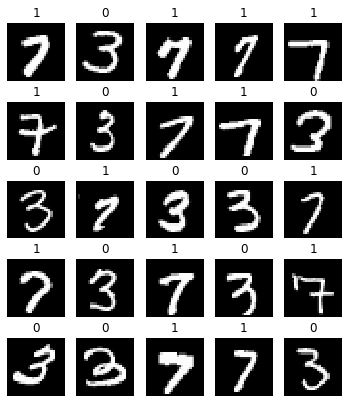


1654784it [01:15, 30736.53it/s]

In [11]:
X, y = next(iter(train_loader))
X = X.numpy() # перевод тензора в массив нумпай, просто изменение типа данных 
y = y.numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

Нам столько размерностей не нужно, поэтому давайте выпрямим матрицу, тем боле мы знаем что значение каждого пикселя независимо друг друга.

In [12]:
X, y = next(iter(train_loader))
X = X.view(X.shape[0], -1)
X.shape

torch.Size([128, 784])

 Размерность
- количество примеров в батче
- количество фичей

In [13]:
y

tensor([1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
        0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0,
        0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 0, 1, 0, 1, 1])

Такой У нам не совсем подходит. Сейчас объясню почему. Размерность Х (128,784) матрично перемножим на скрытый слой (784,1) и получится (128,1). Нужно понимать, что размерность (128,) и (128,1) это немного разные вещи  

In [14]:
w = torch.rand(784, 1) #Рандомные необученые веса
pred = X.matmul(w)
pred.shape

torch.Size([128, 1])

In [15]:
pred

tensor([[-92.5350],
        [ 72.3029],
        [-37.5559],
        [ 20.1835],
        [ 43.2379],
        [ 16.4732],
        [ 82.4012],
        [106.7185],
        [ 48.2822],
        [-50.9488],
        [-27.7844],
        [-11.5578],
        [-44.8626],
        [ 20.0017],
        [ 35.0430],
        [  5.0489],
        [  9.8979],
        [-50.5575],
        [-63.5698],
        [-43.4176],
        [ 67.2807],
        [ 17.3909],
        [-22.3370],
        [ 25.1264],
        [  5.3251],
        [112.2764],
        [-27.4072],
        [-40.7160],
        [ -4.9570],
        [-42.0660],
        [ -2.1478],
        [-18.0416],
        [-16.5017],
        [ 31.9214],
        [ 80.0491],
        [-62.8183],
        [  2.5047],
        [ 18.8550],
        [ 24.1203],
        [ 11.4286],
        [-15.1127],
        [ 77.4194],
        [ 58.9314],
        [-19.7845],
        [ 45.3004],
        [-44.4889],
        [ 77.3399],
        [-23.8954],
        [ 93.4829],
        [ 77.9242],


Теперь у нас есть предсказания и их размерность (128,1). Нужно будет счтить лосс с у, поэтому приведем его к такой же размерности с expand_dims - это функция есть в нумпае, также есть и в торче

In [16]:
y = np.expand_dims(y, 1)

In [17]:
y

array([[1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
    

Итерация по эпохам

In [18]:
epochs = 3

for n_epoch in range(epochs):
    
    dataset_passed_samples = 0
    
    for x, y in train_loader:
        
        # вот здесь мы могли бы как-то манипулировать с данными, например, учить, но пока этого делать не будет
        
        time.sleep(0.05)
        
        dataset_passed_samples += x.shape[0]
        
        dataset_passed_percent = dataset_passed_samples * 100 / train_loader.dataset.data.shape[0]
        
        print(f'Эпоха - {n_epoch + 1}, прошли - {dataset_passed_percent:.2f} % датасета', end='\r')
        
    print('\r')

Эпоха - 1, прошли - 100.00 % датасета
Эпоха - 2, прошли - 100.00 % датасета
Эпоха - 3, прошли - 100.00 % датасета


# Однослойный персептрон

In [19]:
learning_rate = 0.01 # тот самый лернинг рейт, который определяет какую часть от градиента мы будем брать
epochs = 5  #сколько раз мы пройдем по всему тренировачному набору наших данных

batch_size = 128  #это число примеров в баче понадобится нам при обучении чтобы усреднять лосс (ошибку обучения)
n_feat = 784

w1 = np.random.rand(n_feat,1) * 0.01 #0.01 - нормируем таким образом наши веса, чтобы избежать деления на ноль при бэкпропе, 
                                    #эмпирически выбрано, так как сами фичи у нас имеют значения близкие к 0
b1 = np.zeros(1) #размерность должна совпадать с количеством параметров, которые у нас останутся после матричного перемножения

losses = [] #на каждой итерации (и для всех эпох) будем сохранять сюда наш Лосс, чтобы видеть обучается ли НС

for n_epoch in range(epochs):
    
    print(f'Epoch: {n_epoch + 1}')
    
    for x, y in train_loader:

        x = x.view(x.shape[0], -1).numpy() #приводим к размерности (128,784)
        y = np.expand_dims(y.numpy(), 1) #приводим к размерности (128,1)

        h1 = x.dot(w1) + b1 #переход в одномерное пространство
        p = 1/(1+np.exp(-h1)) #преобразование в "вероятности"
        
        bce = (-np.sum(np.multiply(np.log(p), y) + np.multiply((1 - y), np.log(1 - p)))) / batch_size 
        #расчет энтропии с усреднением по размеру бача
          
        losses.append(bce) 
        #ниже производная bce и sigmoid, если вы распишите две этих производные, перемножите и сократите, то полчится следующая строчка
        dp = (p - y) / batch_size 
        dw1 = np.dot(x.T, dp) # производная по линейному преобразванию, относительно W - весов 
        db1 = np.sum(dp) # производная по лин преобразованиюб относительно В - баяса, 
        #здесь по идее должно быть перемножение на единичный вектор (128,1), но это тоже самое что и сумма значениеб типа лайф хак
        
        w1 -= learning_rate * dw1 # Обновим веса и баясы 
        b1 -= learning_rate * db1

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5


А теперь построим график функции потерь

Text(0, 0.5, 'Loss function')

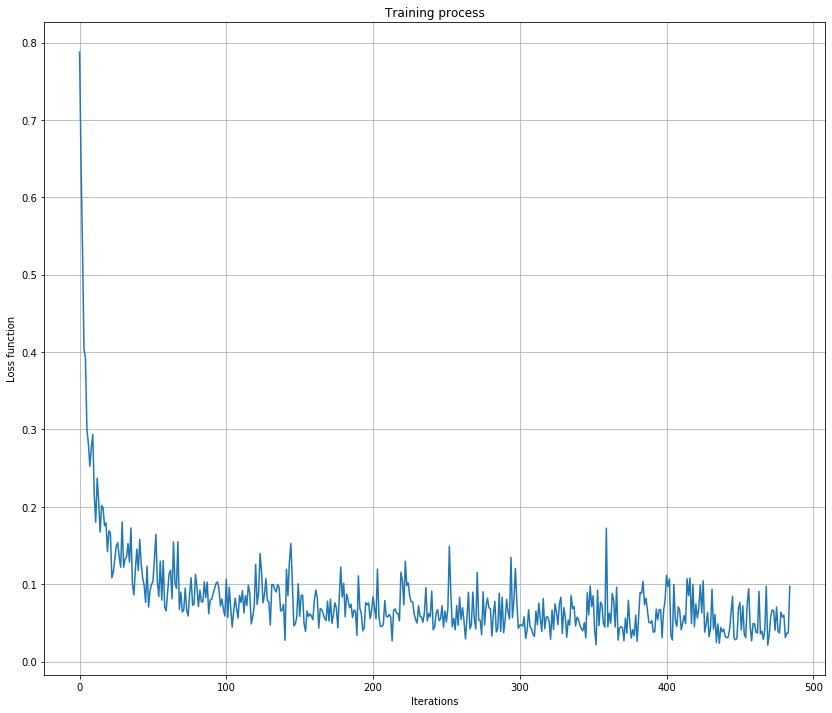

In [20]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function')

## Математика 


![alt text](https://sun9-39.userapi.com/c850608/v850608777/47a4/fgZlI898IUU.jpg)
![alt text](https://sun9-41.userapi.com/c858216/v858216777/cc4f5/v3CPa-tnm80.jpg)
![alt text](https://sun9-67.userapi.com/c857632/v857632471/f6e95/H0dsmWsUInc.jpg)
![alt text](https://sun9-48.userapi.com/c858328/v858328471/ea91a/A3YVz-HwC4w.jpg)

![alt text](https://sun9-5.userapi.com/c857132/v857132471/5016e/y1Jm36sSv9Q.jpg)


А теперь ваша очередь, нужно написать двуслоный персептрон, согласна коду и выкладкам выше

In [81]:
### КОД СЮДА ###

learning_rate = 0.01
epochs = 5
hidden_nodes = 55

w1 = np.random.normal(0.0, pow(n_feat, -0.5), (n_feat, hidden_nodes))
b1 = np.zeros(1) 
w2 = np.random.normal(0.0, pow(hidden_nodes, -0.5), (hidden_nodes, 1))
b2 = np.zeros(1) 

losses = []

for n_epoch in range(epochs):
    
    print(f'Epoch: {n_epoch + 1}')
    
    for x, y in train_loader:
        
        x = x.view(x.shape[0], -1).numpy()
        y = np.expand_dims(y.numpy(), 1)
        
        hidden_layer_1 = x.dot(w1) + b1
        hidden_output_1 = 1 / (1 + np.exp(-hidden_layer_1)) #преобразование в "вероятности"
        
        hidden_layer_2 = hidden_output_1.dot(w2) + b2
        final_output = 1 / (1 + np.exp(-hidden_layer_2))
        
        d_out = y - final_output
        
        hidden_errors = np.dot(d_out, w2.T)
        
        d_hidden_layer_2 = (final_output - y) * (final_output * (1 - final_output))
        d_hidden_layer_1 = d_hidden_layer_2.dot(w2.T) * (hidden_output_1 * (1 - hidden_output_1))
        w2 -= learning_rate * hidden_output_1.T.dot(d_hidden_layer_2)
        b2 -= learning_rate * (1 / batch_size) * np.sum(d_hidden_layer_2)
        w1 -= learning_rate * x.T.dot(d_hidden_layer_1)
        b1 -= learning_rate * (1 / batch_size) * np.sum(d_hidden_layer_1)
        
        loss = (-np.sum(np.log(final_output) * y + (1 - y) * np.log(1 - final_output))) / batch_size 
          
        losses.append(loss)

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5


## Подсказки по размерностям

### Forward

- z1 - первое линейное преобразование - (BATCH_SIZE, INNER_FEATURES)
- a1 - Применение нелинейности - (BATCH_SIZE, INNER_FEATURES)
- z2 - второе нелинейное преобразование - (BATCH_SIZE, 1)
- pred or A2- сигмоида - (BATCH_SIZE, 1)
- loss - функция потерь - скаляр

### Backward

- d_BCE/d_pred - градиент функции потерь по pred - (BATCH_SIZE, 1)
- d_pred/dz2 - градиент сигмоиды по z2 - (BATCH_SIZE, 1)
- dz2/da1 - градиент линейного преобразования по a1 - (BATCH_SIZE, INNER_FEATURES)
- dz2/dw2 - градиент линейного преобразования по w2 - (INNER_FEATURES, 1)
- dz2/db2 - градиент линейного преобразования по b2 - (1,)
- da1/dz1 - градиент нелинейной функции по z1 - (BATCH_SIZE, INNER_FEATURES)
- dz1/dw1 - градиент линейного преобразования по w1 - (IN_FEATURES, INNER_FEATURES)
- dz1/db1 - градиент линейного преобразования по b1 - (INNER_FEATURES,)

и график нарисуйте

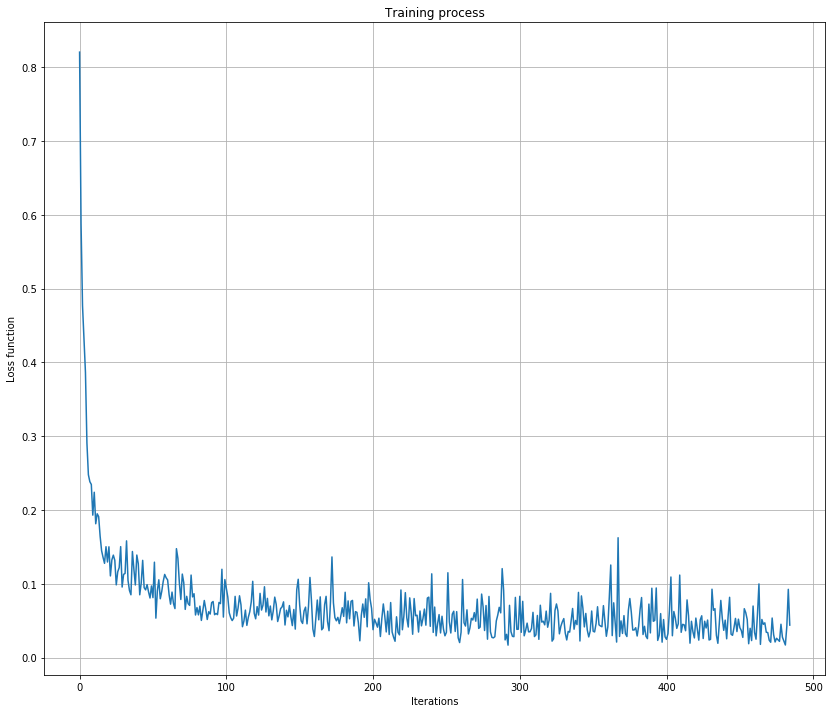

In [82]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function');

# Тестирование

А как это тестировать? Да, очень просто нужно просто выполнять форвард без бэкворда, то есть последовательно применять преобразования с обученными весами

In [75]:
losses_test = []
predicted = []
true_lbls = []

for x, y in test_loader:

    x = x.view(x.shape[0], -1).numpy()
    y = np.expand_dims(y.numpy(), 1)

    h1 = x.dot(w1) + b1 #переход в одномерное пространство
    p = 1/(1+np.exp(-h1)) #преобразование в "вероятности"
  
    bce = (-np.sum(np.multiply(np.log(p), y) + np.multiply((1 - y), np.log(1 - p)))) / batch_size 
    #расчет энтропии с усреднением по размеру бача
    
    losses_test.append(bce)
    predicted.extend(p)
    true_lbls.extend(y) 

Проверим, что для каждого семплау нас есть предсказание

In [76]:
print(len(predicted), len(true_lbls))

2038 2038


Теперь применим стандартную Ф меру и оценим нашу модель

In [77]:
from sklearn.metrics import f1_score
pred = np.array([round(i[0]) for i in predicted]) 
# У нас были вероятности а нужны классы поэтому просто округлим каждое значени и получим лейблы 
t_lbls = np.array(true_lbls).squeeze() #снимем лишнюю размерность
f1 = f1_score(pred, t_lbls, average='weighted')
print('F1 score is equal to: {0:0.02f}'.format(f1))

F1 score is equal to: 0.05


Сделайте тоже самое для своей модели...

In [83]:
losses_test = []
predicted = []
true_lbls = []

for x, y in test_loader:

    x = x.view(x.shape[0], -1).numpy()
    y = np.expand_dims(y.numpy(), 1)

    h1 = x.dot(w1) + b1 #переход в одномерное пространство
    p1 = 1 / ( 1 +np.exp(-h1)) #преобразование в "вероятности"
    
    h2 = h1.dot(w2) + b2
    
    p2 = 1 / (1 + np.exp(-h2))
  
    bce = (-np.sum(np.multiply(np.log(p2), y) + np.multiply((1 - y), np.log(1 - p2)))) / batch_size 
    #расчет энтропии с усреднением по размеру бача
    
    losses_test.append(bce)
    predicted.extend(p2)
    true_lbls.extend(y) 
    
assert len(predicted) == len(true_lbls)

pred = np.array([round(i[0]) for i in predicted]) 
# У нас были вероятности а нужны классы поэтому просто округлим каждое значени и получим лейблы 
t_lbls = np.array(true_lbls).squeeze() #снимем лишнюю размерность
f1 = f1_score(pred, t_lbls, average='weighted')
print('F1 score is equal to: {0:0.02f}'.format(f1))

/home/valeria/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/home/valeria/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in multiply


F1 score is equal to: 0.98


# Немного торча

In [0]:
import torch

### Мы можем определить нашу модель как последовательность уже существующих слоев, как в керасе

In [84]:
model = torch.nn.Sequential()

model.add_module(name='linear_1', module=torch.nn.Linear(in_features=784, out_features=256))
model.add_module(name='relu', module=torch.nn.ReLU())
model.add_module(name='linear_2', module=torch.nn.Linear(in_features=256, out_features=1))
model.add_module(name='sigmoid', module=torch.nn.Sigmoid())

model

Sequential(
  (linear_1): Linear(in_features=784, out_features=256, bias=True)
  (relu): ReLU()
  (linear_2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

### Либо так

In [85]:
model = torch.nn.Sequential(
    torch.nn.Linear(in_features=784, out_features=256),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=256, out_features=1),
    torch.nn.Sigmoid()
)

model

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=1, bias=True)
  (3): Sigmoid()
)

## А вот для чего нужно было писать в домашке классы
## Для определения своих моделей/слоев/чего вам захочется нам нужно сделать такую структуру

In [86]:
# наследуемся от класса torch.nn.Module
class MLP(torch.nn.Module):
    
    # определяем метод __init__
    # он нужен для того, чтобы мы могли определить нужные нам слои, веса, сохраняемые операции
    # 
    # передаем ссылку на самого себя первым параметром
    # 
    # определяем любые другие передаваемые аргументы
    # могут быть чем угодно: числа, словари, другие слои, другие модели и вообще все что угодно
    # 
    def __init__(self, in_features, inner_features, out_features):
        
        # Главная задача этого метода - возможность использования в классе потомке, методов класса-родителя
        # Вызываем __init__ родителя - torch.nn.Module
        super().__init__()
        
        # определяем слои и все что захотим сохранять/использовать
        self.linear_1 = torch.nn.Linear(in_features=in_features, out_features=inner_features)
        self.non_linear_function = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(in_features=inner_features, out_features=out_features)
        self.sigmoid = torch.nn.Sigmoid()
        
    # нам нужно обязательно реализовать метод forward
    # это то, что нашей модели нужно делать, как оперировать с входными данными, как рассчитывать
    # метод backward нам не нужно реализовывать, потому что в торче есть автоматическое дифференцирование
    # главное, чтобы наши операции были дифференцируемы
    # некоторые подробности можете узнать здесь:
    # https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py
    # также список доступных дифференцируемых операций можете посмотреть здесь:
    # https://pytorch.org/docs/stable/tensors.html
    def forward(self, x):
        
        # наша привычная схема
        x = self.linear_1(x)
        x = self.non_linear_function(x)
        x = self.linear_2(x)
        x = self.sigmoid(x)
        
        return x
    
    # мы также можем реализовать любые другие полезные нам методы внутри класса

In [87]:
# определяем нашу модель
model = MLP(in_features=784, inner_features=256, out_features=1)

In [88]:
model

MLP(
  (linear_1): Linear(in_features=784, out_features=256, bias=True)
  (non_linear_function): ReLU()
  (linear_2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [89]:
# можем посмотреть веса
model.linear_1.weight.shape

torch.Size([256, 784])

In [90]:
# еще нам нужно задать функцию потерь 
criterion = torch.nn.BCELoss()

In [91]:
# и оптимизатор, куда нужно передать параметры модели
# параметры модели можно взять методом класса .parameters()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

In [92]:
# можем посмотреть на параметры нашей модели
params = list(model.parameters())
params

[Parameter containing:
 tensor([[-0.0264,  0.0179,  0.0163,  ...,  0.0252,  0.0212, -0.0265],
         [-0.0033,  0.0040, -0.0216,  ...,  0.0045, -0.0356,  0.0179],
         [-0.0120, -0.0297,  0.0030,  ...,  0.0255,  0.0235, -0.0243],
         ...,
         [ 0.0147,  0.0051,  0.0236,  ..., -0.0036, -0.0195, -0.0142],
         [-0.0150, -0.0318,  0.0332,  ..., -0.0124, -0.0324,  0.0175],
         [ 0.0266,  0.0207, -0.0332,  ..., -0.0064, -0.0181,  0.0347]],
        requires_grad=True), Parameter containing:
 tensor([-2.8058e-02,  2.3426e-02,  2.3102e-02,  3.8724e-03,  3.2540e-03,
          1.6446e-02, -7.6172e-03,  1.7564e-03,  2.9356e-02, -9.7743e-03,
         -2.9431e-02, -7.5368e-03,  3.1389e-02, -1.1238e-02, -1.1407e-02,
         -5.0979e-03, -3.3155e-02, -1.6576e-02,  3.0085e-02, -3.3463e-02,
         -1.0029e-02,  1.1140e-02,  1.2409e-02, -1.6117e-02, -2.1671e-02,
         -1.1899e-02,  2.0581e-02,  3.2799e-02, -3.3370e-02,  1.3963e-02,
          2.2881e-02,  2.9080e-02,  2.676

# Обучим нашу модель

In [93]:
# давайте сохранять значения нашей функции потерь каждую итерацию обучения
losses = []

# эта штука все еще отдает нам батчи данных
# мы поговорим про нее позже
for x, y in train_loader:

    x = x.view(x.shape[0], -1)
    y = y.unsqueeze(1).float()
    
    # обновим наши градиенты
    # будем делать это каждую итерацию обучения
    # потому что торч сохраняет в себе все градиенты пока не удалите таким образом рассчитанные градиенты
    # 
    # НЕОБЯЗАТЕЛЬНЫЕ ДЕТАЛИ
    # функция сохранения градиентов нужна для аккамуляции градиентов
    # например, когда нам не хватает памяти на большой батч
    # мы можем несколько раз прогнать forward на разных батчах
    # наши градиенты будут сохраняться
    # и только потом обновить через несколько итераций forward обновить наши веса
    # таким образом у нас получается больше батч
    # 
    optimizer.zero_grad()
    
    # 
    # предсказание нашей модели
    # здесь торч сам сохраняет необходимую информацию
    # чтобы понять эту логику у нас как раз и была часть домашки про собственные классы
    # 
    # торч строит динамический граф вычислений
    # то есть строит граф по тем операциям, которые вы определили в методе forward
    # 
    # то есть торч понимает, что вы сначала применили линейное преобразование
    # знает, где лежат веса для этого линейного преобразования
    # знает, что вы затем применили релу
    # затем опять линейное преобразование
    # затем сигмоиду
    # и вот таким образом торч выстроил граф
    # который нужен будет для backpropogation
    # 
    pred = model(x)
    
    # 
    # рассчитываем функцию потерь, добавляя в наш граф вычислений этот узел
    # 
    loss = criterion(pred, y.float())
    
    # 
    # вызываем метод backward() от нашей функции потерь (это крайний узел нашего графа вычислений)
    # этот метод проходит от конца графа в начало, вычисляя необходимые градиенты
    # передаем градиенты на следующие узлы
    # для весов сохраняет
    # 
    # то есть это почти то же самое, что мы делали в домашке с классами
    # 
    loss.backward()
    
    # 
    # теперь мы знаем необходимые градиенты и можем обновить веса с помощью градиентного спуска
    # 
    optimizer.step()
    
    # 
    # сохраним текущее значение функции потерь, чтобы потом могли посмотреть на график
    # очень важный момент: нам нужно отсоединить значение нашей фунции потерь от графа вычислений
    # чтобы граф не строился дальше на каждой итерации обучения
    # так мы рано или поздно переполним память
    # поэтому вызываем этот метод
    # работает для скаляров
    # 
    # для тензоров работает метод .tolist()
    # 
    current_loss_value = loss.item()
    losses.append(loss.item())

In [94]:
# Одна эпоха прошла

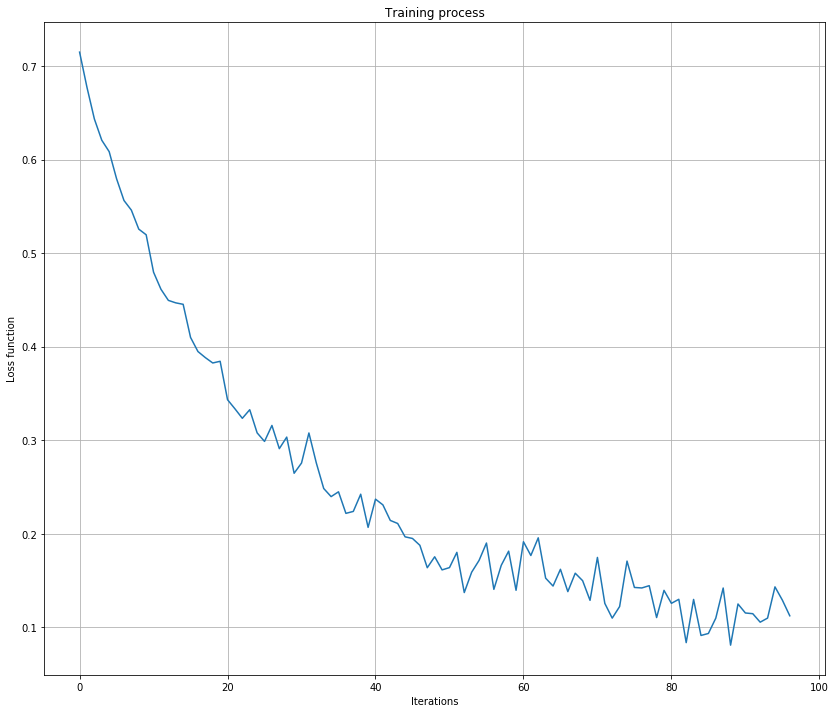

In [95]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function');

# Теперь мы можем что-то предсказать

In [96]:
for x, y in test_loader:

    x = x.view(x.shape[0], -1)
    y = y.unsqueeze(1).float()
    
    # чтобы не ходить по всему тестовому датасету, прекратим ходить после первой итерации
    break

In [97]:
x.shape

torch.Size([128, 784])

In [98]:
y.shape

torch.Size([128, 1])

In [99]:
# переходим в режим предсказания
# 
# позже в курсе мы разберем зачем конкретно это нужно
# 
# для искушенного нетерпеливого читателя: дропаут больше не дропаутит, батч норм больше не нормирует каждый батч
# а использует накопленную статистику при обучении и тд
# 
model.eval()

MLP(
  (linear_1): Linear(in_features=784, out_features=256, bias=True)
  (non_linear_function): ReLU()
  (linear_2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [100]:
# этот контект позволяет не сохранять необходимую информацию для рассчета градиентов
with torch.no_grad():

    pred = model(x)

In [101]:
pred.shape

torch.Size([128, 1])

In [102]:
# избавимся от единичной размерности
pred = pred.squeeze()
y = y.squeeze()

In [103]:
pred.shape

torch.Size([128])

In [104]:
# таким образом из торчовых тензоров мы можем сделать нумпаевские массивы
pred = pred.numpy()
y = y.numpy()

In [105]:
y

array([1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.,
       0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1.,
       0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 1., 1., 0., 1., 0., 0., 1.], dtype=float32)

In [106]:
type(y)

numpy.ndarray

In [107]:
# бинаризируем наши предсказания
pred[pred > 0.5] = 1
pred[pred <= 0.5] = 0

In [108]:
# посчитаем метрику на батче
accuracy_score(y, pred)

0.9609375

In [109]:
# заново определим нашу модель и выучимся несколько эпох
# будут уже новые параметры
model = MLP(in_features=784, inner_features=256, out_features=1)

criterion = torch.nn.BCELoss()
# мы позже поговорим про этот оптимизационный алгоритм
optimizer = torch.optim.Adam(params=model.parameters())

# Типичный цикл обучения с кучей сохранений лоссов

In [110]:
epochs = 10
losses = []
# нужно для early stopping, то есть трекать лучший лосс на валидации
best_test_loss = 10.

for n_epoch in range(epochs):
    
    train_losses = []
    test_losses = []
    test_preds = []
    test_targets = []
    
    progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))
    
    for x, y in train_loader:
        
        x = x.view(x.shape[0], -1)
        y = y.unsqueeze(1).float()
        
        optimizer.zero_grad()
        
        pred = model(x)
        
        loss = criterion(pred, y.float())
        
        loss.backward()
        
        optimizer.step()
        
        train_losses.append(loss.item())
        losses.append(loss.item())
        
        progress_bar.set_postfix(train_loss = np.mean(losses[-100:]))

        progress_bar.update(x.shape[0])
        
    progress_bar.close()
    
    for x, y in test_loader:
        
        x = x.view(x.shape[0], -1)
        y = y.unsqueeze(1).float()

        with torch.no_grad():
            
            pred = model(x)
            
        test_preds.append(pred.numpy())
        test_targets.append(y.numpy())

        loss = criterion(pred, y)

        test_losses.append(loss.item())
        
    mean_test_loss = np.mean(test_losses)
        
    print('Losses: train - {:.3f}, test = {:.3f}'.format(np.mean(train_losses), mean_test_loss))
    
    test_preds = np.concatenate(test_preds)
    test_preds = test_preds.squeeze()
    test_targets = np.concatenate(test_targets).squeeze()
    
    test_preds[test_preds > 0.5] = 1
    test_preds[test_preds <= 0.5] = 0
    
    accurary = accuracy_score(test_targets, test_preds)

    print('Test: accuracy - {:.3f}'.format(accurary))
        
    # как раз early stopping
    # то есть: если наша функция потерь на валидационном датасете стала расти, то прекращаем обучение
    # рост фунции потерь на валидационном датасете говорит о переобучении
    # пожалуй, самый популярный метод валидации для нейронных сетей
    if mean_test_loss < best_test_loss:
        best_test_loss = mean_test_loss
    else:
        print('Early stopping')
        break    



Epoch 1:   0%|          | 0/12396 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/12396 [00:00<?, ?it/s, train_loss=0.683]

Epoch 1:   1%|          | 128/12396 [00:00<00:09, 1271.25it/s, train_loss=0.564]

Epoch 1:   2%|▏         | 256/12396 [00:00<00:05, 2337.39it/s, train_loss=0.564]

Epoch 1:   2%|▏         | 256/12396 [00:00<00:05, 2337.39it/s, train_loss=0.461]

Epoch 1:   3%|▎         | 384/12396 [00:00<00:05, 2337.39it/s, train_loss=0.396]

Epoch 1:   4%|▍         | 512/12396 [00:00<00:05, 2212.49it/s, train_loss=0.396]

Epoch 1:   4%|▍         | 512/12396 [00:00<00:05, 2212.49it/s, train_loss=0.342]

Epoch 1:   5%|▌         | 640/12396 [00:00<00:05, 2212.49it/s, train_loss=0.299]

Epoch 1:   6%|▌         | 768/12396 [00:00<00:05, 2105.65it/s, train_loss=0.299]

Epoch 1:   6%|▌         | 768/12396 [00:00<00:05, 2105.65it/s, train_loss=0.268]

Epoch 1:   7%|▋         | 896/12396 [00:00<00:05, 2105.65it/s, train_loss=0.245]

Epoch 1:   8%|▊         | 1024/12396 [00:00<00:05, 2105.

Epoch 1:  66%|██████▌   | 8192/12396 [00:03<00:01, 2318.78it/s, train_loss=0.0819]

Epoch 1:  66%|██████▌   | 8192/12396 [00:03<00:01, 2318.78it/s, train_loss=0.0809]

Epoch 1:  67%|██████▋   | 8320/12396 [00:03<00:01, 2318.78it/s, train_loss=0.0799]

Epoch 1:  68%|██████▊   | 8448/12396 [00:03<00:01, 2313.03it/s, train_loss=0.0799]

Epoch 1:  68%|██████▊   | 8448/12396 [00:03<00:01, 2313.03it/s, train_loss=0.0788]

Epoch 1:  69%|██████▉   | 8576/12396 [00:03<00:01, 2313.03it/s, train_loss=0.078] 

Epoch 1:  70%|███████   | 8704/12396 [00:03<00:01, 2057.04it/s, train_loss=0.078]

Epoch 1:  70%|███████   | 8704/12396 [00:03<00:01, 2057.04it/s, train_loss=0.078]

Epoch 1:  71%|███████   | 8832/12396 [00:04<00:01, 2057.04it/s, train_loss=0.0774]

Epoch 1:  72%|███████▏  | 8960/12396 [00:04<00:01, 2145.43it/s, train_loss=0.0774]

Epoch 1:  72%|███████▏  | 8960/12396 [00:04<00:01, 2145.43it/s, train_loss=0.0764]

Epoch 1:  73%|███████▎  | 9088/12396 [00:04<00:01, 2145.43it/s, train_loss=0.0

Losses: train - 0.070, test = 0.053
Test: accuracy - 0.980




Epoch 2:   4%|▍         | 512/12396 [00:00<00:03, 3165.63it/s, train_loss=0.0585]

Epoch 2:   5%|▌         | 640/12396 [00:00<00:04, 2441.68it/s, train_loss=0.0585]

Epoch 2:   5%|▌         | 640/12396 [00:00<00:04, 2441.68it/s, train_loss=0.057] 

Epoch 2:   6%|▌         | 768/12396 [00:00<00:04, 2441.68it/s, train_loss=0.0553]

Epoch 2:   7%|▋         | 896/12396 [00:00<00:04, 2441.68it/s, train_loss=0.0542]

Epoch 2:   8%|▊         | 1024/12396 [00:00<00:04, 2477.86it/s, train_loss=0.0542]

Epoch 2:   8%|▊         | 1024/12396 [00:00<00:04, 2477.86it/s, train_loss=0.0543]

Epoch 2:   9%|▉         | 1152/12396 [00:00<00:04, 2477.86it/s, train_loss=0.0543]

Epoch 2:  10%|█         | 1280/12396 [00:00<00:05, 2162.27it/s, train_loss=0.0543]

Epoch 2:  10%|█         | 1280/12396 [00:00<00:05, 2162.27it/s, train_loss=0.0536]

Epoch 2:  11%|█▏        | 1408/12396 [00:00<00:05, 2162.27it/s, train_loss=0.0529]

Epoch 2:  12%|█▏        | 1536/12396 [00:00<00:05, 1935.08it/s, train_loss=0.05

Epoch 2:  69%|██████▉   | 8576/12396 [00:04<00:02, 1698.37it/s, train_loss=0.0356]

Epoch 2:  69%|██████▉   | 8576/12396 [00:04<00:02, 1698.37it/s, train_loss=0.0358]

Epoch 2:  70%|███████   | 8704/12396 [00:04<00:02, 1698.37it/s, train_loss=0.0359]

Epoch 2:  71%|███████   | 8832/12396 [00:04<00:02, 1705.13it/s, train_loss=0.0359]

Epoch 2:  71%|███████   | 8832/12396 [00:04<00:02, 1705.13it/s, train_loss=0.0359]

Epoch 2:  72%|███████▏  | 8960/12396 [00:04<00:02, 1705.13it/s, train_loss=0.0358]

Epoch 2:  73%|███████▎  | 9088/12396 [00:04<00:01, 1761.31it/s, train_loss=0.0358]

Epoch 2:  73%|███████▎  | 9088/12396 [00:04<00:01, 1761.31it/s, train_loss=0.0352]

Epoch 2:  74%|███████▍  | 9216/12396 [00:04<00:01, 1761.31it/s, train_loss=0.0349]

Epoch 2:  75%|███████▌  | 9344/12396 [00:04<00:01, 1761.31it/s, train_loss=0.035] 

Epoch 2:  76%|███████▋  | 9472/12396 [00:04<00:01, 1977.81it/s, train_loss=0.035]

Epoch 2:  76%|███████▋  | 9472/12396 [00:04<00:01, 1977.81it/s, train_loss=0.

Losses: train - 0.027, test = 0.035
Test: accuracy - 0.989




Epoch 3:   4%|▍         | 512/12396 [00:00<00:04, 2962.65it/s, train_loss=0.0265]

Epoch 3:   5%|▌         | 640/12396 [00:00<00:04, 2508.20it/s, train_loss=0.0265]

Epoch 3:   5%|▌         | 640/12396 [00:00<00:04, 2508.20it/s, train_loss=0.0263]

Epoch 3:   6%|▌         | 768/12396 [00:00<00:06, 1827.31it/s, train_loss=0.0263]

Epoch 3:   6%|▌         | 768/12396 [00:00<00:06, 1827.31it/s, train_loss=0.0271]

Epoch 3:   7%|▋         | 896/12396 [00:00<00:06, 1827.31it/s, train_loss=0.0264]

Epoch 3:   8%|▊         | 1024/12396 [00:00<00:05, 1899.40it/s, train_loss=0.0264]

Epoch 3:   8%|▊         | 1024/12396 [00:00<00:05, 1899.40it/s, train_loss=0.0255]

Epoch 3:   9%|▉         | 1152/12396 [00:00<00:05, 1899.40it/s, train_loss=0.0252]

Epoch 3:  10%|█         | 1280/12396 [00:00<00:05, 1899.40it/s, train_loss=0.0252]

Epoch 3:  11%|█▏        | 1408/12396 [00:00<00:05, 2111.66it/s, train_loss=0.0252]

Epoch 3:  11%|█▏        | 1408/12396 [00:00<00:05, 2111.66it/s, train_loss=0.024

Epoch 3:  73%|███████▎  | 9088/12396 [00:03<00:01, 2144.87it/s, train_loss=0.0173]

Epoch 3:  74%|███████▍  | 9216/12396 [00:03<00:01, 1969.26it/s, train_loss=0.0173]

Epoch 3:  74%|███████▍  | 9216/12396 [00:03<00:01, 1969.26it/s, train_loss=0.0173]

Epoch 3:  75%|███████▌  | 9344/12396 [00:03<00:01, 1969.26it/s, train_loss=0.0173]

Epoch 3:  76%|███████▋  | 9472/12396 [00:03<00:01, 1892.53it/s, train_loss=0.0173]

Epoch 3:  76%|███████▋  | 9472/12396 [00:03<00:01, 1892.53it/s, train_loss=0.0174]

Epoch 3:  77%|███████▋  | 9600/12396 [00:03<00:01, 1892.53it/s, train_loss=0.0173]

Epoch 3:  78%|███████▊  | 9728/12396 [00:03<00:01, 1915.41it/s, train_loss=0.0173]

Epoch 3:  78%|███████▊  | 9728/12396 [00:03<00:01, 1915.41it/s, train_loss=0.0173]

Epoch 3:  80%|███████▉  | 9856/12396 [00:03<00:01, 1915.41it/s, train_loss=0.0173]

Epoch 3:  81%|████████  | 9984/12396 [00:03<00:01, 1915.41it/s, train_loss=0.0171]

Epoch 3:  82%|████████▏ | 10112/12396 [00:03<00:01, 2069.29it/s, train_loss=

Losses: train - 0.016, test = 0.023
Test: accuracy - 0.992




Epoch 4:   2%|▏         | 256/12396 [00:00<00:06, 1802.12it/s, train_loss=0.0154]

Epoch 4:   3%|▎         | 384/12396 [00:00<00:06, 1802.12it/s, train_loss=0.0154]

Epoch 4:   4%|▍         | 512/12396 [00:00<00:06, 1829.76it/s, train_loss=0.0154]

Epoch 4:   4%|▍         | 512/12396 [00:00<00:06, 1829.76it/s, train_loss=0.0154]

Epoch 4:   5%|▌         | 640/12396 [00:00<00:06, 1829.76it/s, train_loss=0.015] 

Epoch 4:   6%|▌         | 768/12396 [00:00<00:07, 1634.79it/s, train_loss=0.015]

Epoch 4:   6%|▌         | 768/12396 [00:00<00:07, 1634.79it/s, train_loss=0.015]

Epoch 4:   7%|▋         | 896/12396 [00:00<00:07, 1634.79it/s, train_loss=0.0148]

Epoch 4:   8%|▊         | 1024/12396 [00:00<00:06, 1634.79it/s, train_loss=0.0148]

Epoch 4:   9%|▉         | 1152/12396 [00:00<00:06, 1758.30it/s, train_loss=0.0148]

Epoch 4:   9%|▉         | 1152/12396 [00:00<00:06, 1758.30it/s, train_loss=0.0139]

Epoch 4:  10%|█         | 1280/12396 [00:00<00:06, 1758.30it/s, train_loss=0.0139]



Epoch 4:  70%|███████   | 8704/12396 [00:03<00:01, 2455.77it/s, train_loss=0.0102]

Epoch 4:  70%|███████   | 8704/12396 [00:03<00:01, 2455.77it/s, train_loss=0.0108]

Epoch 4:  71%|███████   | 8832/12396 [00:03<00:01, 2455.77it/s, train_loss=0.0108]

Epoch 4:  72%|███████▏  | 8960/12396 [00:03<00:01, 2446.33it/s, train_loss=0.0108]

Epoch 4:  72%|███████▏  | 8960/12396 [00:03<00:01, 2446.33it/s, train_loss=0.0103]

Epoch 4:  73%|███████▎  | 9088/12396 [00:03<00:01, 2446.33it/s, train_loss=0.0102]

Epoch 4:  74%|███████▍  | 9216/12396 [00:03<00:01, 2371.94it/s, train_loss=0.0102]

Epoch 4:  74%|███████▍  | 9216/12396 [00:04<00:01, 2371.94it/s, train_loss=0.0101]

Epoch 4:  75%|███████▌  | 9344/12396 [00:04<00:01, 2371.94it/s, train_loss=0.0101]

Epoch 4:  76%|███████▋  | 9472/12396 [00:04<00:01, 2371.94it/s, train_loss=0.0104]

Epoch 4:  77%|███████▋  | 9600/12396 [00:04<00:01, 2465.38it/s, train_loss=0.0104]

Epoch 4:  77%|███████▋  | 9600/12396 [00:04<00:01, 2465.38it/s, train_loss=0

Losses: train - 0.009, test = 0.021
Test: accuracy - 0.993




Epoch 5:   5%|▌         | 640/12396 [00:00<00:03, 3564.95it/s, train_loss=0.00881]

Epoch 5:   6%|▌         | 768/12396 [00:00<00:03, 3564.95it/s, train_loss=0.0087] 

Epoch 5:   7%|▋         | 896/12396 [00:00<00:03, 3276.77it/s, train_loss=0.0087]

Epoch 5:   7%|▋         | 896/12396 [00:00<00:03, 3276.77it/s, train_loss=0.00864]

Epoch 5:   8%|▊         | 1024/12396 [00:00<00:03, 3276.77it/s, train_loss=0.00863]

Epoch 5:   9%|▉         | 1152/12396 [00:00<00:03, 3276.77it/s, train_loss=0.00867]

Epoch 5:  10%|█         | 1280/12396 [00:00<00:03, 3150.64it/s, train_loss=0.00867]

Epoch 5:  10%|█         | 1280/12396 [00:00<00:03, 3150.64it/s, train_loss=0.00872]

Epoch 5:  11%|█▏        | 1408/12396 [00:00<00:03, 3150.64it/s, train_loss=0.00877]

Epoch 5:  12%|█▏        | 1536/12396 [00:00<00:03, 3150.64it/s, train_loss=0.0086] 

Epoch 5:  13%|█▎        | 1664/12396 [00:00<00:03, 2977.02it/s, train_loss=0.0086]

Epoch 5:  13%|█▎        | 1664/12396 [00:00<00:03, 2977.02it/s, train

Epoch 5:  74%|███████▍  | 9216/12396 [00:03<00:01, 2736.34it/s, train_loss=0.00602]

Epoch 5:  75%|███████▌  | 9344/12396 [00:03<00:01, 2736.34it/s, train_loss=0.0061] 

Epoch 5:  76%|███████▋  | 9472/12396 [00:03<00:01, 2736.34it/s, train_loss=0.00646]

Epoch 5:  77%|███████▋  | 9600/12396 [00:03<00:01, 2563.87it/s, train_loss=0.00646]

Epoch 5:  77%|███████▋  | 9600/12396 [00:03<00:01, 2563.87it/s, train_loss=0.00644]

Epoch 5:  78%|███████▊  | 9728/12396 [00:03<00:01, 2563.87it/s, train_loss=0.00649]

Epoch 5:  80%|███████▉  | 9856/12396 [00:03<00:00, 2563.87it/s, train_loss=0.00627]

Epoch 5:  81%|████████  | 9984/12396 [00:03<00:00, 2555.31it/s, train_loss=0.00627]

Epoch 5:  81%|████████  | 9984/12396 [00:03<00:00, 2555.31it/s, train_loss=0.00617]

Epoch 5:  82%|████████▏ | 10112/12396 [00:03<00:00, 2555.31it/s, train_loss=0.0062]

Epoch 5:  83%|████████▎ | 10240/12396 [00:03<00:00, 2555.31it/s, train_loss=0.0063]

Epoch 5:  84%|████████▎ | 10368/12396 [00:03<00:00, 2626.60it/s, 

Losses: train - 0.006, test = 0.022
Test: accuracy - 0.993
Early stopping


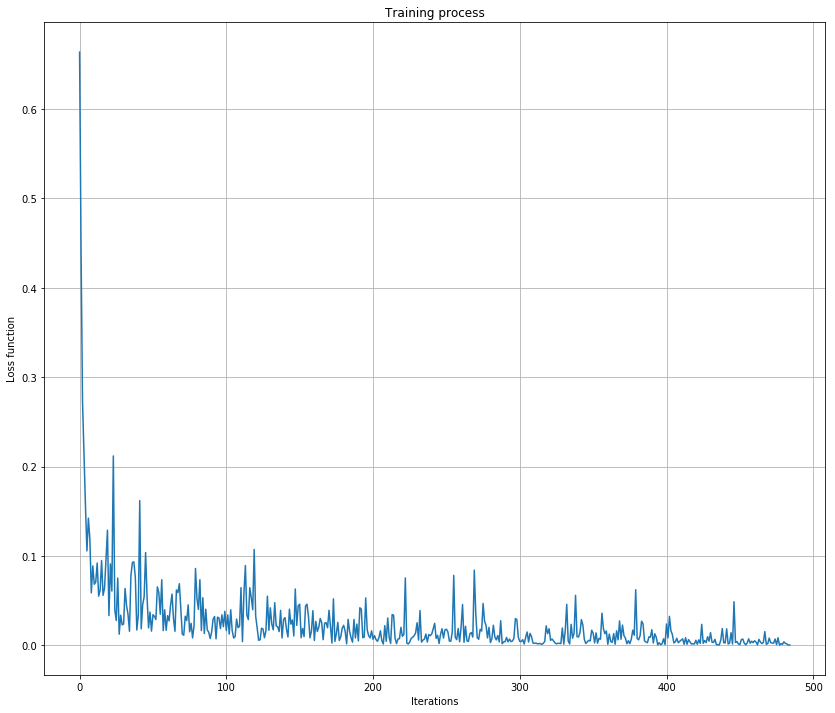

In [0]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function');

# Word2vec